In [1]:
# Importing the required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt

2023-07-13 23:52:17.417703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 23:52:17.648679: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 23:52:17.651718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 23:52:18.637292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data=pd.read_csv(r"full.csv", index_col=False)
data

,Thickness,Reynolds,Mach,alpha,CL,CD
0,5.0,0.03,0.0,-10.0,-0.7146,0.14439
1,5.0,0.03,0.0,-9.5,-0.6741,0.13070
2,5.0,0.03,0.0,-9.0,-0.6831,0.12660
3,5.0,0.03,0.0,-8.5,-0.6694,0.11953
4,5.0,0.03,0.0,-8.0,-0.6482,0.11072
...,...,...,...,...,...,...
34875,24.0,3.00,0.0,8.0,0.8866,0.01897
34876,24.0,3.00,0.0,8.5,0.9273,0.02141
34877,24.0,3.00,0.0,9.0,0.9643,0.02421
34878,24.0,3.00,0.0,9.5,0.9899,0.02781


In [3]:
# Generating training, testing and validation data
naca_sequence = np.arange(5, 25)
# Choosing 6 random values of NACA thichkness from the 30 available
part_naca_sequence = np.random.choice(naca_sequence, 4, replace = False)

# Creating numpy arrays of NACA values for training, validation and testing
training_naca = list(naca_sequence.copy())
for i in part_naca_sequence:
    training_naca.remove(i)

np.random.shuffle(part_naca_sequence)
validation_naca = part_naca_sequence[0:2]
testing_naca = part_naca_sequence[2:]

# Creating pandas dataframe of NACA values for training, validation and testing
training_data = data[data['Thickness'].isin(training_naca)]
validation_data = data[data['Thickness'].isin(validation_naca)]
testing_data = data[data['Thickness'].isin(testing_naca)]

# Shuffling them
training_data = training_data.sample(frac=1)
validation_data = validation_data.sample(frac=1)
testing_data = testing_data.sample(frac=1)

tr_input=training_data.iloc[:,:4]
tr_output=training_data.iloc[:,4:]

te_input=testing_data.iloc[:,:4]
te_output=testing_data.iloc[:,4:]

va_input=validation_data.iloc[:,:4]
va_output=validation_data.iloc[:,4:]

print(tr_input.shape , tr_output.shape,te_input.shape , te_output.shape,va_input.shape, va_output.shape )

(27802, 4) (27802, 2) (3659, 4) (3659, 2) (3419, 4) (3419, 2)


In [4]:
# Performing hypeerparameters
def build_model(hp):
    model = Sequential()
    model.add(Dense(units = hp.Int('units',25, 35, step = 5), input_dim = 4, activation='relu'))

    for i in range(hp.Int('layers', 3, 4)):
        model.add(Dense(
            units = hp.Int('units_' + str(i), 25, 35, step = 10),
            activation = 'relu'))
    model.add(Dense(2, activation = None))
    
    model.compile(loss = 'mean_squared_error', 
                optimizer = hp.Choice('optimiser', ['rmsprop', 'Adam', 'SGD']),
                metrics = ['accuracy'])
    
    return model

In [5]:
tuner = kt.Hyperband(
    build_model,
    objective = 'val_accuracy',
    max_epochs = 5,
    hyperband_iterations = 2
    )

tuner.search_space_summary()

Search space summary
Default search space size: 6
units (Int)
{'default': None, 'conditions': [], 'min_value': 25, 'max_value': 35, 'step': 5, 'sampling': 'linear'}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 25, 'max_value': 35, 'step': 10, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 25, 'max_value': 35, 'step': 10, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 25, 'max_value': 35, 'step': 10, 'sampling': 'linear'}
optimiser (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'Adam', 'SGD'], 'ordered': False}


In [6]:
tuner.search(x=tr_input, y=tr_output , epochs=10, validation_data = (va_input, va_output))
tuner.results_summary()

model = tuner.get_best_models(1)[0]

Trial 20 Complete [00h 00m 08s]
val_accuracy: 0.9707517027854919

Best val_accuracy So Far: 0.9730915427207947
Total elapsed time: 00h 01m 42s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0001 summary
Hyperparameters:
units: 25
layers: 3
units_0: 35
units_1: 25
units_2: 25
optimiser: SGD
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9730915427207947

Trial 0009 summary
Hyperparameters:
units: 30
layers: 4
units_0: 25
units_1: 35
units_2: 25
optimiser: Adam
units_3: 25
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9730915427207947

Trial 0007 summary
Hyperparameters:
units: 25
layers: 4
units_0: 25
units_1: 35
units_2: 25
optimiser: Adam
units_3: 35
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9707517027854919

Trial 0017 summary
Hyperparameters:
units: 30
layers: 3
unit

In [7]:
model.fit(x=tr_input, y=tr_output , epochs=10, validation_data = (va_input, va_output))

Epoch 1/10
869/869 [==============================] - 2s 2ms/step - loss: 0.0162 - accuracy: 0.9712 - val_loss: 0.0227 - val_accuracy: 0.9731
Epoch 2/10
869/869 [==============================] - 1s 1ms/step - loss: 0.0157 - accuracy: 0.9716 - val_loss: 0.0249 - val_accuracy: 0.9658
Epoch 3/10
869/869 [==============================] - 1s 1ms/step - loss: 0.0152 - accuracy: 0.9718 - val_loss: 0.0256 - val_accuracy: 0.9731
Epoch 4/10
869/869 [==============================] - 1s 1ms/step - loss: 0.0150 - accuracy: 0.9728 - val_loss: 0.0224 - val_accuracy: 0.9690
Epoch 5/10
869/869 [==============================] - 1s 2ms/step - loss: 0.0148 - accuracy: 0.9732 - val_loss: 0.0204 - val_accuracy: 0.9719
Epoch 6/10
869/869 [==============================] - 1s 1ms/step - loss: 0.0145 - accuracy: 0.9738 - val_loss: 0.0218 - val_accuracy: 0.9567
Epoch 7/10
869/869 [==============================] - 1s 2ms/step - loss: 0.0144 - accuracy: 0.9730 - val_loss: 0.0205 - val_accuracy: 0.9567
Epoch 

In [8]:
te_prediction=model.predict(te_input)

# Calculating mean square error
rows = te_output.shape[0]
predict_CL = te_prediction[:,0]
predict_CD = te_prediction[:,1]
actual_CL = te_output['CL'].to_numpy()
actual_CD = te_output['CD'].to_numpy()

error=np.zeros(2, dtype = float)

error[0] = 1/rows*np.sum(np.square(predict_CL-actual_CL))
error[1] = 1/rows*np.sum(np.square(actual_CD-predict_CD))

print(error)

115/115 [==============================] - 0s 849us/step
[0.03688304 0.00143648]


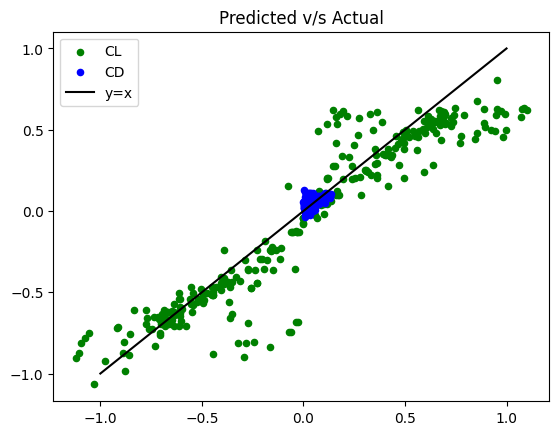

In [9]:
plt.scatter(actual_CL[:300], predict_CL[:300], color="green", s=20, label = 'CL')
plt.scatter(actual_CD[:300],predict_CD[:300], color="blue", s= 20, label = 'CD')
plt.plot(np.linspace(-1,1), np.linspace(-1,1), color = 'black', label = 'y=x')
plt.title("Predicted v/s Actual")
plt.legend(loc = 'upper left')

In [10]:
def generate_data_csv():
    Thickness = float(input("Enter the value of NACA thickness percentage for symmetrical airfoil: "))
    Reynolds = float(input("Enter the value of Reynolds number: "))
    Mach = float(input("Enter the value of Mach number: "))
    
    alpha = np.linspace(-10, 10, num = 41, endpoint = True)
    thickness_array = [Thickness]*41
    Reynolds_array = [Reynolds]*41
    Mach_array = [Mach]*41

    df_input = pd.DataFrame(np.array([thickness_array, Reynolds_array, Mach_array, alpha]).T, columns = ['Thickness', 'Reynolds', 'Mach', 'alpha'])
    df_predict = pd.DataFrame(model.predict(df_input), columns=['CL', 'CD'])

    df = pd.concat([df_input, df_predict], axis=1)

    filename = 'NACA 00' + str(Thickness) + ' Re' + str(Reynolds) + ' Ma' + str(Mach) + '.csv'
    print(filename)
    df.to_csv(filename, index = False)

generate_data_csv()

2/2 [==============================] - 0s 3ms/step
NACA 001.0 Re1.0 Ma1.0.csv
